In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_root = pathlib.Path('../../dataset/4500')

# save (img_path, label) pairs
train_csv_path = '../../csv/4500/train.csv'
val_csv_path = '../../csv/4500/val.csv'
test_csv_path = '../../csv/4500/test.csv'

In [3]:
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

BUFFER_SIZE = 100
BATCH_SIZE = 64

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

NUM_EPOCH = 30
LEARNING_RATE = 1e-5

In [4]:
# data_root = pathlib.Path('./dataset/4500')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif', 'bmp', 'ini')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)
# print(f'all image path = {all_image_paths}')

classes:
..\..\dataset\4500\owner
..\..\dataset\4500\shipper

total img num: 4500


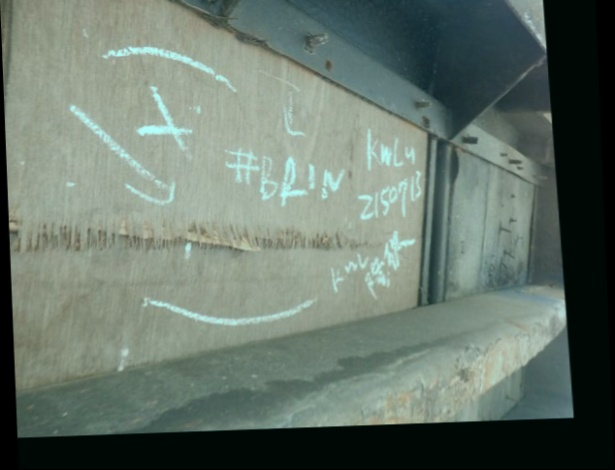

shipper


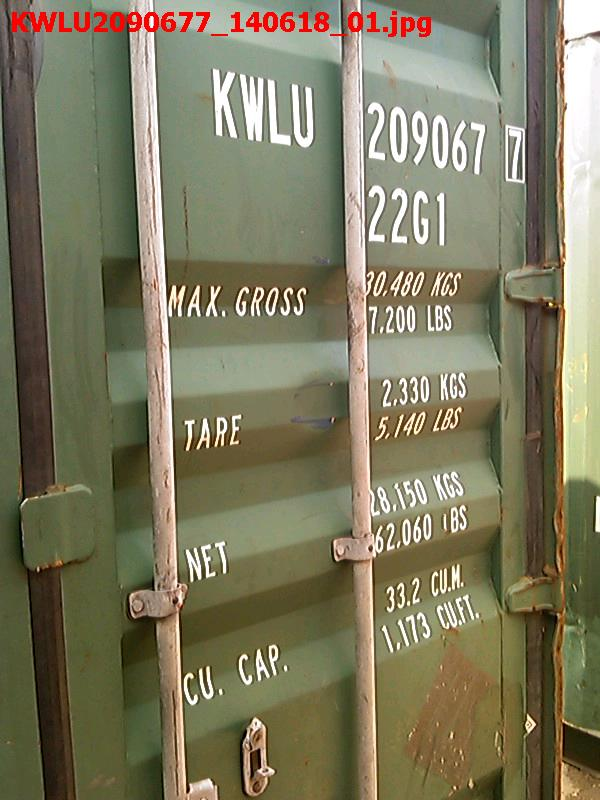

owner


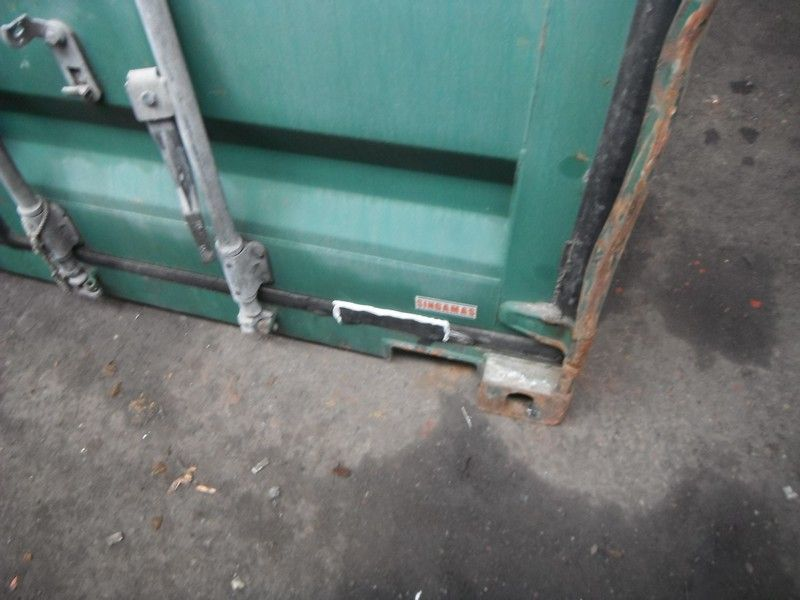

owner


In [5]:
# random showing 3 iamges 
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])
    # print(image_path.split(os.path.sep)[-2])
    # print(image_path.split('/')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['owner', 'shipper']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'owner': 0, 'shipper': 1}


In [8]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [1, 1, 0, 0, 0, 1, 1, 0, 1, 0]


In [9]:
# Create training:validation:testing sets using an 80-10-10 split
img_path_train, img_path_val_and_test, label_train, label_val_and_test = train_test_split(all_image_paths, 
                                                                                          all_image_label,
                                                                                          test_size=0.2,
                                                                                          random_state=0)
img_path_val, img_path_test, label_val, label_test = train_test_split(img_path_val_and_test, 
                                                                      label_val_and_test, 
                                                                      test_size=0.5, 
                                                                      random_state=0)


print('training data: %d'%(len(img_path_train)))
print('validation data: %d'%(len(img_path_val)))
print('testing data: %d'%(len(img_path_test)))

training data: 3600
validation data: 450
testing data: 450


In [10]:
# save (img_path, label) pairs
with open(train_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open(val_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])
        
with open(test_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [11]:
class SimpleDataset(tf.data.Dataset):
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(SimpleDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        img_paths, label = open_file(filename)

        # Reading the file
        for sample_idx in range(len(img_paths)):
            img = read_file(img_paths[sample_idx])
            yield img, label[sample_idx]

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )


In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return SimpleDataset(train_csv_path, open_file, read_file)

def dataset_generator_fun_val(*args):
    return SimpleDataset(val_csv_path, open_file, read_file)

def dataset_generator_fun_test(*args):
    return SimpleDataset(test_csv_path, open_file, read_file)

In [13]:
# parse training data
@tf.function
def map_fun(image, label):
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    return distorted_image, label

# parse validation data
@tf.function
def map_fun_val(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

# parse testing data
@tf.function
def map_fun_test(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

In [14]:
dataset_train = tf.data.Dataset.range(1)\
                               .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE, seed=SEED)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                               .cache()\
                               .prefetch(tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.range(1)\
                               .interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE, seed=SEED)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .map(map_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                               .cache()\
                               .prefetch(tf.data.AUTOTUNE)

dataset_test = tf.data.Dataset.range(1)\
                              .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                              .batch(BATCH_SIZE, drop_remainder=True)\
                              .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                              .cache()\
                              .prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


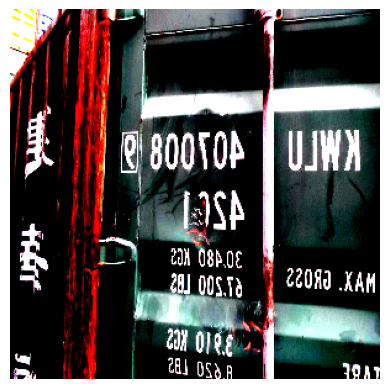

owner


In [15]:
for img, label in dataset_train.take(1):
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [16]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [17]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [18]:
# save the initialization of weights 
# wild_model.save_weights('../../weight/WildModel/wild_model.h5')

In [19]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [20]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))
    
#     print("Label shape:", label.shape)
#     print("Predictions shape:", predictions.shape)

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def val_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    val_loss(loss)
    val_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    return loss, label, predictions

In [21]:
train_loss_list = []
val_loss_list = []

def epoch_loop(dataset_train, dataset_test, EPOCHS):
    for epoch in range(EPOCHS):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        tf.print("training:")
        for image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            train_step(image, label)

        tf.print("validating:")
        for image, label in tqdm(dataset_val, total=math.floor(len(img_path_val)/BATCH_SIZE)):
            val_step(image, label)
            
        train_loss_list.append(train_loss.result().numpy())
        val_loss_list.append(val_loss.result().numpy())

            
        template = 'Epoch {:0}, Training loss: {:.4f}, Training accuracy: {:.4f}, Validation loss: {:.4f}, Validation Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))
        
        # Save weights after each epoch
        wild_model.save_weights('../../weight/WildModel/wild_model_epoch_{}.h5'.format(epoch + 1), overwrite=True)

In [22]:
# wild_model.load_weights('../../weight/WildModel/wild_model.h5')
epoch_loop(dataset_train, dataset_val, EPOCHS= NUM_EPOCH)

training:


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]

validating:



100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

Epoch 1, Training loss: 0.3884, Training accuracy: 83.8170, Validation loss: 0.2246, Validation Accuracy: 92.8571


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 2, Training loss: 0.2123, Training accuracy: 91.5458, Validation loss: 0.2132, Validation Accuracy: 92.6339


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 3, Training loss: 0.1779, Training accuracy: 92.7176, Validation loss: 0.1948, Validation Accuracy: 94.4196


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 4, Training loss: 0.1436, Training accuracy: 94.1685, Validation loss: 0.1979, Validation Accuracy: 94.4196


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 5, Training loss: 0.1179, Training accuracy: 95.0335, Validation loss: 0.1927, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 6, Training loss: 0.0993, Training accuracy: 96.0658, Validation loss: 0.1946, Validation Accuracy: 94.8661


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 7, Training loss: 0.0860, Training accuracy: 96.7355, Validation loss: 0.1853, Validation Accuracy: 94.6429


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.20it/s]

Epoch 8, Training loss: 0.0723, Training accuracy: 97.1819, Validation loss: 0.2182, Validation Accuracy: 94.6429


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 9, Training loss: 0.0648, Training accuracy: 97.4609, Validation loss: 0.2108, Validation Accuracy: 94.6429


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 10, Training loss: 0.0476, Training accuracy: 98.2980, Validation loss: 0.2256, Validation Accuracy: 94.4196


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 11, Training loss: 0.0385, Training accuracy: 98.7723, Validation loss: 0.2054, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 12, Training loss: 0.0358, Training accuracy: 98.8002, Validation loss: 0.2122, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.89it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 13, Training loss: 0.0280, Training accuracy: 99.2746, Validation loss: 0.2552, Validation Accuracy: 94.6429


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 14, Training loss: 0.0220, Training accuracy: 99.4420, Validation loss: 0.2412, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

Epoch 15, Training loss: 0.0205, Training accuracy: 99.4420, Validation loss: 0.2406, Validation Accuracy: 94.8661


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

Epoch 16, Training loss: 0.0178, Training accuracy: 99.6094, Validation loss: 0.2250, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

Epoch 17, Training loss: 0.0137, Training accuracy: 99.7768, Validation loss: 0.2385, Validation Accuracy: 94.8661


training:


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

Epoch 18, Training loss: 0.0161, Training accuracy: 99.5815, Validation loss: 0.2308, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

Epoch 19, Training loss: 0.0102, Training accuracy: 99.8884, Validation loss: 0.2322, Validation Accuracy: 95.5357


training:


100%|██████████| 56/56 [00:11<00:00,  4.91it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch 20, Training loss: 0.0110, Training accuracy: 99.6931, Validation loss: 0.2267, Validation Accuracy: 95.0893
training:


100%|██████████| 56/56 [00:11<00:00,  5.02it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

Epoch 21, Training loss: 0.0121, Training accuracy: 99.6931, Validation loss: 0.2444, Validation Accuracy: 95.5357


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 22, Training loss: 0.0076, Training accuracy: 99.8884, Validation loss: 0.2770, Validation Accuracy: 95.3125


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 23, Training loss: 0.0071, Training accuracy: 99.9163, Validation loss: 0.2629, Validation Accuracy: 94.8661
training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 24, Training loss: 0.0054, Training accuracy: 99.9163, Validation loss: 0.2830, Validation Accuracy: 94.8661


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 25, Training loss: 0.0055, Training accuracy: 99.9442, Validation loss: 0.2812, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

Epoch 26, Training loss: 0.0070, Training accuracy: 99.8605, Validation loss: 0.3121, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 27, Training loss: 0.0055, Training accuracy: 99.8884, Validation loss: 0.3132, Validation Accuracy: 94.8661


training:


100%|██████████| 56/56 [00:11<00:00,  5.01it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.27it/s]

Epoch 28, Training loss: 0.0033, Training accuracy: 100.0000, Validation loss: 0.3029, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.27it/s]

Epoch 29, Training loss: 0.0025, Training accuracy: 100.0000, Validation loss: 0.3154, Validation Accuracy: 95.0893


training:


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]

validating:



100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 30, Training loss: 0.0034, Training accuracy: 99.9163, Validation loss: 0.3267, Validation Accuracy: 95.0893


In [23]:
wild_model.load_weights(f'../../weight/WildModel/wild_model_epoch_{NUM_EPOCH}.h5')

true_label = []
predicted_label = []

def test_loop(dataset_test):
    for image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
        loss, labels, predictions = test_step(image, label)
        
        true_label.extend(labels.numpy())
        predicted_label.extend(tf.argmax(predictions, axis=1).numpy())
        
        test_loss(loss)
        test_accuracy(labels, predictions)

    template = 'Test loss: {:.4f}, Test accuracy: {:.4f}'
    tf.print(template.format(test_loss.result(), test_accuracy.result()*100))

test_loop(dataset_test)

100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

Test loss: 0.2401, Test accuracy: 93.7500


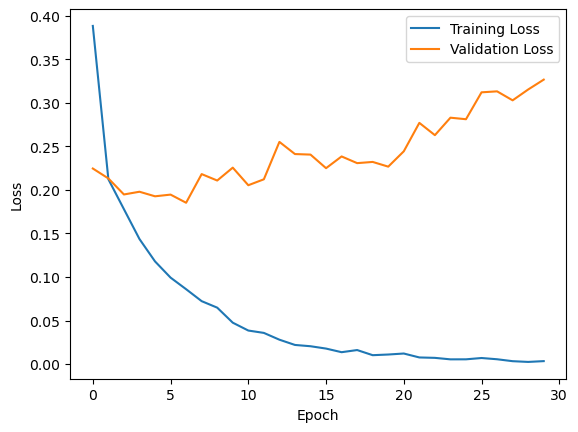

In [24]:
# Plot training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

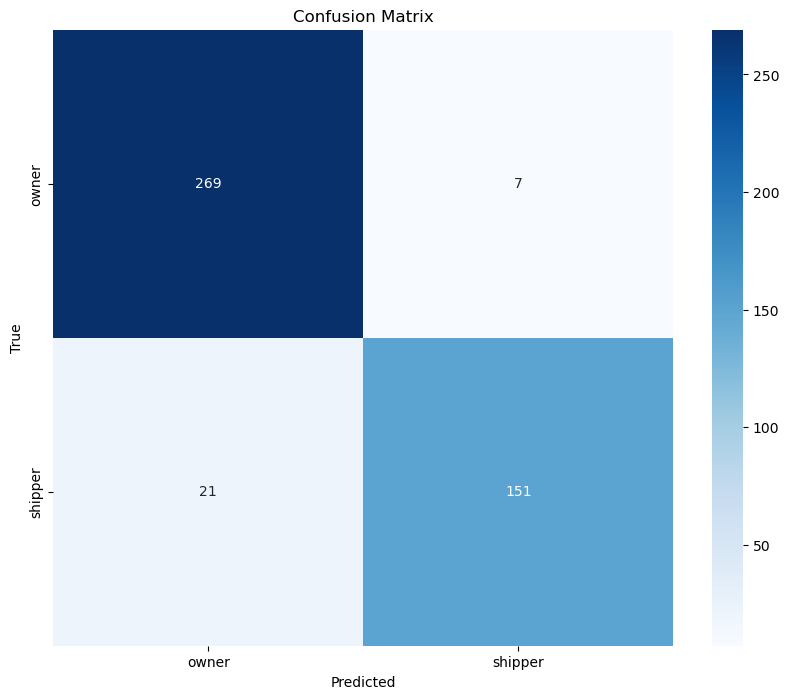

In [25]:
cm = confusion_matrix(true_label, predicted_label)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()